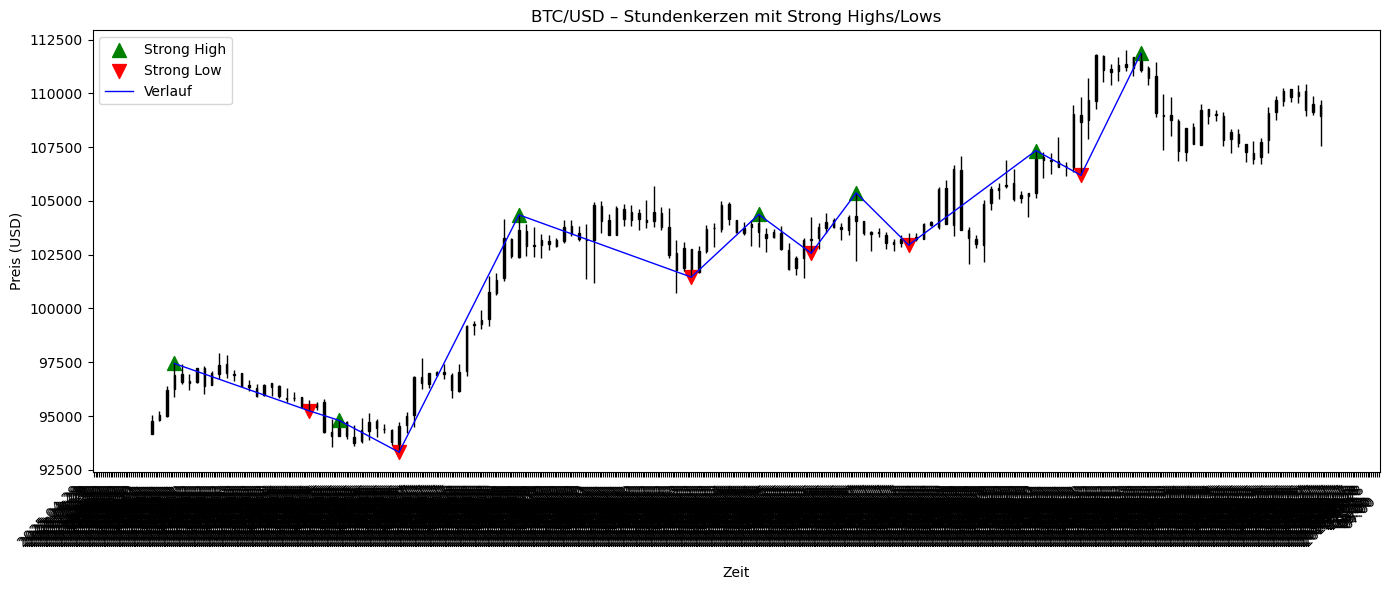

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

# ─── 1) CSV LADEN & VORBEREITUNG ───────────────────────────────
# Ersetze 'data.csv' durch den Pfad zu deiner Datei
df = pd.read_csv(
    'btc_bars_data.csv',
    parse_dates=['timestamp'],
    index_col='timestamp'
)
# Falls eine Zeitzone vorhanden ist, entfernen:
df.index = df.index.tz_convert(None)
# Nur benötigte Spalten behalten
df = df[['open', 'high', 'low', 'close']]

# ─── 2) HILFSFUNKTIONEN ────────────────────────────────────────
def find_max_high(df, idxs):
    subset = df.iloc[idxs]
    t = subset['high'].idxmax()
    return {'time': t, 'price': subset.loc[t, 'high']}

def find_min_low(df, idxs):
    subset = df.iloc[idxs]
    t = subset['low'].idxmin()
    return {'time': t, 'price': subset.loc[t, 'low']}

# ─── 3) STATE-MACHINE FÜR STRONG HIGHS/LOWS ────────────────────
def detect_structure(df):
    structure = []
    state      = 'looking_high'
    run_color  = None
    run_len    = 0
    candidate  = None

    for i in range(len(df)):
        color = 'green' if df['close'].iat[i] > df['open'].iat[i] else 'red'

        # Laufende Farbsequenz updaten
        if color == run_color:
            run_len += 1
        else:
            run_color, run_len = color, 1

        # Zustands-Logik
        if state == 'looking_high' and color == 'red' and run_len == 2 and i >= 2:
            candidate = find_max_high(df, [i-2, i-1, i])
            state = 'await_high'

        elif state == 'await_high':
            if color == 'green' and run_len == 2:
                structure.append(('Strong High', candidate['time'], candidate['price']))
                candidate, run_len = None, 0
                state = 'looking_low'
            elif color == 'red' and run_len == 2:
                new_wh = find_max_high(df, [i-2, i-1, i])
                if new_wh['price'] > candidate['price']:
                    candidate = new_wh

        elif state == 'looking_low' and color == 'green' and run_len == 2 and i >= 2:
            candidate = find_min_low(df, [i-2, i-1, i])
            state = 'await_low'

        elif state == 'await_low':
            if color == 'red' and run_len == 2:
                structure.append(('Strong Low', candidate['time'], candidate['price']))
                candidate, run_len = None, 0
                state = 'looking_high'
            elif color == 'green' and run_len == 2:
                new_wl = find_min_low(df, [i-2, i-1, i])
                if new_wl['price'] < candidate['price']:
                    candidate = new_wl

    return pd.DataFrame(structure, columns=['type', 'time', 'price'])

# ─── 4) ERKENNUNG AUSFÜHREN ────────────────────────────────────
structure_df = detect_structure(df)

# ─── 5) GRAFISCHE DARSTELLUNG ──────────────────────────────────
# Breite der Kerzenkörper (80% einer Stunde in Tagen)
width = 1/24 * 0.8

# Marker-Daten
times_sh  = mdates.date2num(structure_df.loc[structure_df['type']=='Strong High','time'].dt.to_pydatetime())
prices_sh = structure_df.loc[structure_df['type']=='Strong High','price'].values
times_sl  = mdates.date2num(structure_df.loc[structure_df['type']=='Strong Low' ,'time'].dt.to_pydatetime())
prices_sl = structure_df.loc[structure_df['type']=='Strong Low' ,'price'].values
times_all = mdates.date2num(structure_df['time'].dt.to_pydatetime())
prices_all= structure_df['price'].values

# Plot
fig, ax = plt.subplots(figsize=(14,6))

# Candlesticks manuell zeichnen
for idx, row in df.iterrows():
    t = mdates.date2num(idx)
    o, h, l, c = row['open'], row['high'], row['low'], row['close']
    color = 'green' if c > o else 'red'
    # Docht
    ax.vlines(t, l, h, color='black', linewidth=1)
    # Körper
    rect = mpatches.Rectangle(
        (t - width/2, min(o, c)),
        width,
        abs(c - o),
        facecolor=color,
        edgecolor='black'
    )
    ax.add_patch(rect)

# Pfeile für Strong High / Strong Low
ax.scatter(times_sh, prices_sh, marker='^', s=100, color='green', label='Strong High')
ax.scatter(times_sl, prices_sl, marker='v', s=100, color='red',   label='Strong Low')

# Verbindungslinie
ax.plot(times_all, prices_all, '-', lw=1, color='blue', label='Verlauf')

# xticks stündlich
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Beschriftungen & Legende
ax.set_xlabel('Zeit')
ax.set_ylabel('Preis (USD)')
plt.title('BTC/USD – Stundenkerzen mit Strong Highs/Lows')
ax.legend(loc='best')
plt.tight_layout()
plt.show()